In [ ]:
# manipulacja danymi
import numpy as np
import pandas as pd

# wizualizacja
import matplotlib.pyplot as plt
import seaborn as sns

# podział danych na zbiory treningowe/walidacyjne/testowe
from sklearn.model_selection import train_test_split, GridSearchCV

# budowa Pipeline
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, PowerTransformer

# redukcja wymiarowości
from sklearn.decomposition import PCA

# model
from sklearn.linear_model import LogisticRegression

# ewaluacja
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, f1_score, roc_auc_score

In [ ]:
dataset = pd.read_csv('diabetes.csv')
dataset

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
0,1354778,0,171,80,34,23,43.509726,1.213191,21,0
1,1147438,8,92,93,47,36,21.240576,0.158365,23,0
2,1640031,7,115,47,52,35,41.511523,0.079019,23,0
3,1883350,9,103,78,25,304,29.582192,1.282870,43,1
4,1424119,1,85,59,27,35,42.604536,0.549542,22,0
...,...,...,...,...,...,...,...,...,...,...
14995,1490300,10,65,60,46,177,33.512468,0.148327,41,1
14996,1744410,2,73,66,27,168,30.132636,0.862252,38,1
14997,1742742,0,93,89,43,57,18.690683,0.427049,24,0
14998,1099353,0,132,98,18,161,19.791645,0.302257,23,0


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PatientID               15000 non-null  int64  
 1   Pregnancies             15000 non-null  int64  
 2   PlasmaGlucose           15000 non-null  int64  
 3   DiastolicBloodPressure  15000 non-null  int64  
 4   TricepsThickness        15000 non-null  int64  
 5   SerumInsulin            15000 non-null  int64  
 6   BMI                     15000 non-null  float64
 7   DiabetesPedigree        15000 non-null  float64
 8   Age                     15000 non-null  int64  
 9   Diabetic                15000 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 1.1 MB


In [ ]:
features = ['Pregnancies','PlasmaGlucose','DiastolicBloodPressure','TricepsThickness','SerumInsulin','BMI','DiabetesPedigree','Age']
target = 'Diabetic'
X, y = dataset[features], dataset[target]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [ ]:
metrics_dataframe = pd.DataFrame(columns = ['Model', 'F1_score', 'AUC'])
metrics_dataframe
models = []
models_names = []
predictions_proba_list = []
def calculate_metrics(model, name, X_checked, y_checked):
    models.append(model)
    models_names.append(name)
    global metrics_dataframe
    predictions = model.predict(X_checked)
    predictions_proba = model.predict_proba(X_checked)
    predictions_proba_list.append(predictions_proba[:,1])

    ############## metryki dla sprawdzanego modelu ################
    # Precision, Recall, F1, Accuracy
    print(classification_report(y_checked, predictions))

    # Confusion matrix
    plt.figure()
    cm = confusion_matrix(y_checked, predictions)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
    ax.set_title('Confusion Matrix\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    plt.show()

    # plot ROC curve
    fig = plt.figure(figsize=(6, 6))
    plt.plot([0, 1], [0, 1], 'k--')
    for model_selected, name_selected, pred_proba in zip(models, models_names, predictions_proba_list):
        fpr, tpr, thresholds = roc_curve(y_checked, pred_proba)
        plt.plot(fpr, tpr, label=name_selected)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    f1_metric = f1_score(y_checked, predictions)
    auc_metric = roc_auc_score(y_checked, predictions_proba[:,1])
    metrics_dataframe = metrics_dataframe.append({'Model': name, 'F1_score': f1_metric, 'AUC': auc_metric},
                                                 ignore_index=True)
    return metrics_dataframe

In [ ]:
scaler_2var = StandardScaler()
X_train_standardized = scaler_2var.fit_transform(X_train)
X_test_standardized = scaler_2var.transform(X_test)
model_lr = LogisticRegression()
model_lr.fit(X_train_standardized, y_train)

LogisticRegression()

              precision    recall  f1-score   support

           0       0.82      0.88      0.85      2500
           1       0.72      0.60      0.65      1250

    accuracy                           0.79      3750
   macro avg       0.77      0.74      0.75      3750
weighted avg       0.78      0.79      0.78      3750



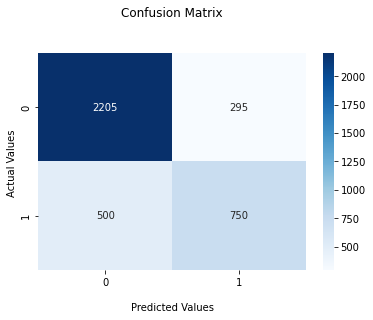

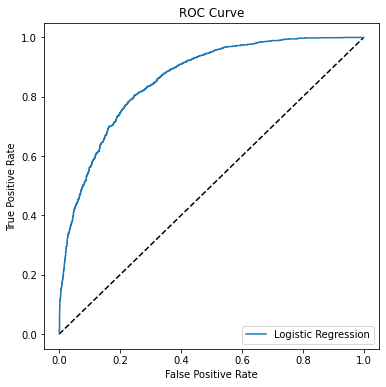

,Model,F1_score,AUC
0,Logistic Regression,0.653595,0.859502


In [ ]:
calculate_metrics(model_lr, 'Logistic Regression', X_test_standardized, y_test)

In [ ]:
# przygotowanie wartości numerycznych
num_preparation = Pipeline(steps=[
    ('logtransformer',PowerTransformer()),
    ('polynomial_features', PolynomialFeatures(degree=3)),
    ('scaler_1', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('scaler_2', StandardScaler())
])

In [ ]:
model_pipeline_v1 = Pipeline(steps=[('preprocessor', num_preparation),
                                    ('model', LogisticRegression(max_iter=10000))])

In [ ]:
model_pipeline_v1.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('logtransformer', PowerTransformer()),
                                 ('polynomial_features',
                                  PolynomialFeatures(degree=3)),
                                 ('scaler_1', StandardScaler()),
                                 ('pca', PCA(n_components=0.95)),
                                 ('scaler_2', StandardScaler())])),
                ('model', LogisticRegression(max_iter=10000))])

              precision    recall  f1-score   support

           0       0.90      0.91      0.90      2500
           1       0.81      0.80      0.80      1250

    accuracy                           0.87      3750
   macro avg       0.86      0.85      0.85      3750
weighted avg       0.87      0.87      0.87      3750



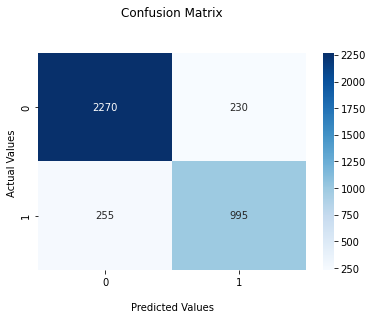

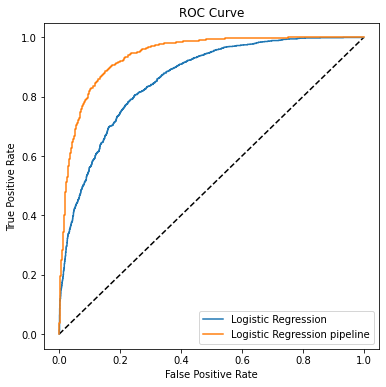

,Model,F1_score,AUC
0,Logistic Regression,0.653595,0.859502
1,Logistic Regression pipeline,0.804040,0.939705


In [ ]:
calculate_metrics(model_pipeline_v1, 'Logistic Regression pipeline', X_test, y_test)